# Optimizing Neural Networks

To remind, necessary ingredients to train NN:
    * model
    * objective
    * optimizer
    
Today we will try to understand basics of optimization of neural networks, giving context for the last two lectures. Goal is to:
* Understand basics of generalization, and the difference between optimization and generalization (more on that in "Understanding generalization" lab)
* Understand impact of hyperparameters in SGD on:

  - generalization (lr, batch size)
  - speed of optimization (lr, momentum, batch size) 

References:
* Deep Learning book chapter on optimization: http://www.deeplearningbook.org/contents/optimization.html

# Setup

In [25]:
# Boilerplate code to get started

%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src.fmnist_utils import build_mlp, train

def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1: optimization speed

Assuming fixed number of *epochs*, it is usually better to use either smaller batch size, or larger learning rate. Theoretical reason for it is not completely clear, so let's focus in this exercise on an empirical investigation.

Assume you are allowed to train the given network for 10 epochs. Answer the following questions:

* a) What was the optimal $\eta$ (assuming $S$=128 and $\mu$=0.9) for the final training accuracy?
* b) Did it also provide the best test accuracy? If yes, why (hint: consider if model is under or over-fitting)?
* c) What is the optimal $S$ (assuming $\eta$=0.1 and $\mu$=0.9) for the final training accuracy?
* d) Why is higher learning rate, or smaller batch size, optimizing faster? Give your best explanation (it can be hypothetical, there is no obvious theoretical answer)?

In [23]:
# Some starting code. Loop through different LR and BS and find optimal ones.
model = build_mlp(784, 10, hidden_dim=512)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=10)

100%|██████████| 10/10 [00:00<00:00, 13.84it/s]


In [24]:
answers = {"a": "", "b": "", "c": "", "d": ""}
json.dump(answers, open("7b_ex1.json", "w"))

# Exercise 2: generalization

Story with generalization is also unclear, but it is generally accepted that higher noise levels in SGD lead to better generalization. Think of noise in optimization (leading to low fidelity, as seen in lab 7a, for instance) as a close analog of typical regularizations (like dropout or batch normalization, that we will discuss next time).

Your task is to:

a) Implement the stability measure described below. How is the stability measure evolving during training?

b) Check a range of LR and BS and find the best generalizing combination of LR and BS. What test accuracy were you able to achieve? What is the best LR and BS combination?

c) Answer the following question: Is stability correlated with using large LR or small BS. If yes, what is the intuitive reason for it? Feel free to give a hypothesis, there is no stricly correct or incorrect answer.

In [73]:
answers = {"a": "", "b": "", "c": ""}
json.dump(answers, open("7b_ex2.json", "w"))

## Stability measure

In 7a lab we discussed bias/variance view. Here, we will take a stability based view. To estimate stability, 
we will record maximum change in prediction when adding gaussian noise to examples. This is a very rudimentary
way to estimate geometric margin of the network, and we will talk more about this later.

In [42]:
# Some starting code. Loop through different LR and BS and find optimal ones.
model = build_mlp(784, 10, hidden_dim=512)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=10)

100%|██████████| 10/10 [00:00<00:00, 10.74it/s]


In [134]:
def measure_stability(model, x_train, sigma=0.001, K=10, N=1000):
    # Take top N examples. Compute original classifications
    x_train_N = x_train[0:N].numpy()
    y_train_N = model.forward(torch.autograd.Variable(x_train[0:N]))
    y_train_N = y_train_N.data.numpy()
    
    # Duplicate K times
    x_train_N = np.repeat(x_train_N, K, axis=0)
    y_train_N = np.repeat(y_train_N, K, axis=0)

    # Resample with noise, repackage to torch Tensor
    x_train_N = x_train_N + np.random.normal(0, sigma, size=x_train_N.shape)
    
    # Predict
    x_train_N = torch.from_numpy(x_train_N).type(torch.FloatTensor)
    y_train_N_pred = model.forward(torch.autograd.Variable(x_train_N))
    
    # Measure maximum difference
    y_train_N_pred = y_train_N_pred.data.numpy().reshape(K, N, -1)
    
    # MSE difference
    dif = np.linalg.norm(y_train_N_pred - y_train_N.reshape(K, N, -1), axis=-1)
    dif = np.max(dif, axis=0)
    dif = np.mean(dif, axis=0)
    
    return dif

In [144]:
# Some rudimentary sanity checks
assert measure_stability(model, x_train, sigma=0.01) < measure_stability(model, x_train, sigma=0.1) 
assert measure_stability(model, x_train, sigma=0.0) < 1e-4

## Finding optimal $\eta$ and $S$

In [135]:
# We have to modify training loop to include measuring stability inside

def train_with_stability_measure(model, loss, optim, 
          x_train, y_train, x_test, y_test, batch_size=100, n_epochs=10):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42) 
    n_examples, n_features = x_train.size()
    history = {"acc": [], "test_acc": [], "stability": []}
    for i in tqdm.tqdm(range(n_epochs), total=n_epochs):
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
        
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
        
        # Stability estimation
        history['stability'].append(measure_stability(model, x_train))
 
        # Usually it is computed from per batch averages, but I compute
        # here using the whole train set to reduce level of noise in the learning curves
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

In [136]:
Hs = []
Lrs = [0.001, 0.05, 0.1, 0.2]
for lr in Lrs:
    model = build_mlp(784, 10, hidden_dim=512)
    loss = torch.nn.CrossEntropyLoss(size_average=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    H = train_with_stability_measure(loss=loss, model=model, x_train=x_train, y_train=y_train,
              x_test=x_test, y_test=y_test,
              optim=optimizer, batch_size=128, n_epochs=20)
    Hs.append(H)

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


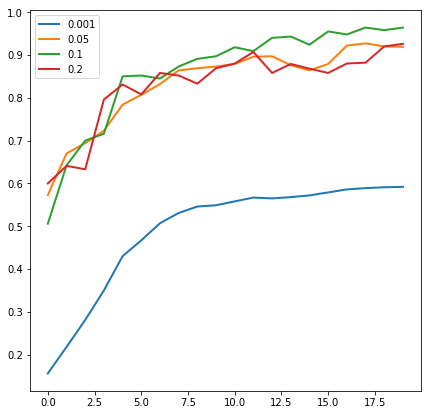

In [139]:
for H, LR in zip(Hs, Lrs):
    plt.plot(H['acc'], label=LR)
plt.legend()

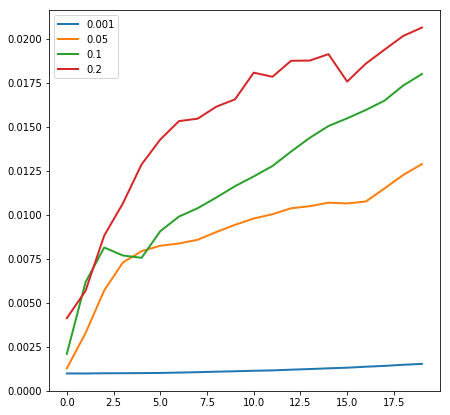

In [140]:
for H, LR in zip(Hs, Lrs):
    plt.plot(H['stability'], label=LR)
plt.legend()